In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
# cpdag with only direct edge
df = pd.read_csv("../../result/DAGMA/dagma_cpdag.tsv", sep="\t", header=None)
df = df.loc[df[2]=="directed", 0:1]
df.columns = ['source', 'target']
g = nx.from_pandas_edgelist(df, create_using=nx.DiGraph)

In [3]:
result = pd.Series(nx.betweenness_centrality(g)).to_frame().reset_index()
result.columns = ['gene', 'btw']
result = result.sort_values('btw', ascending=False).reset_index(drop=True)

In [4]:
df = pd.read_csv("../../data/perturb/clustered_mean_gene_expression_figs2-4.csv", sep=",", index_col=0, low_memory=False)
df = df.iloc[2:, 1:]
name2mean = df.mean(axis=1).to_dict()
name2std = df.std(axis=1).to_dict()
id2name = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t", index_col=0)["genes"].to_dict()
dagma = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", header=None, sep="\t")
dagma[0] = dagma[0].map(id2name)
dagma[1] = dagma[1].map(id2name)
dagma_gene = set.union(set(dagma[0]), set(dagma[1]))
genes = pd.DataFrame(list(id2name.values()))
genes["ExpMean"] = genes[0].map(name2mean)
genes["ExpStd"] = genes[0].map(name2std)
genes["CoreDAG"] = genes[0].isin(dagma_gene)

In [5]:
result = pd.merge(result, genes, left_on='gene', right_on=0)
result['Betweeness'] = "High"
result.loc[result['btw']<0.009, 'Betweeness'] = "Low"

In [6]:
result['ExpMean'] = result['ExpMean'].abs()

In [7]:
btw_genes = result[result['Betweeness'] == "High"]['gene'].values

neighbor1 = []
for gene in btw_genes:
    neighbor1 += list(g.neighbors(gene))

neighbor1 = list(set(neighbor1) - set(btw_genes))

In [8]:
neighbor2 = []
for gene in neighbor1:
    neighbor2 += list(g.neighbors(gene))
neighbor2 = list(set(neighbor2) - set(neighbor1) - set(btw_genes))

In [9]:
result['Type'] = 'Other'
result.loc[result['Betweeness']=='High', 'Type'] = 'High_btw'
result.loc[result['gene'].isin(neighbor1), 'Type'] = 'Neighbor1'
result.loc[result['gene'].isin(neighbor2), 'Type'] = 'Neighbor2'
result = result.sort_values("Type").reset_index(drop=True)

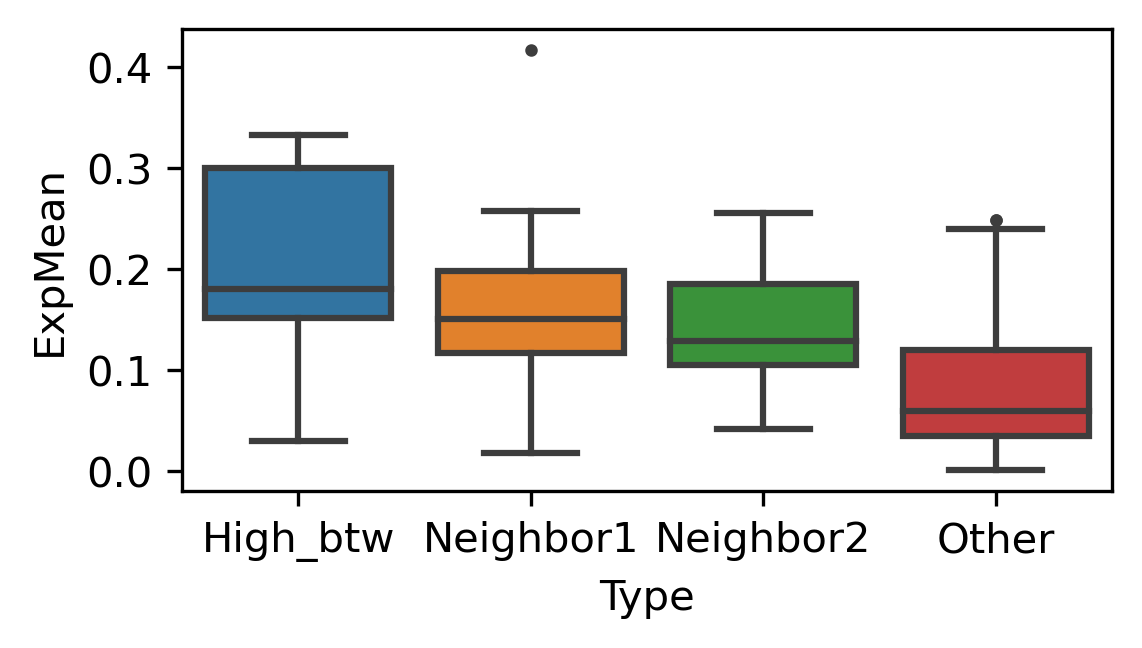

In [10]:
plt.figure(dpi=300, figsize=(4,2))
flierprops = dict(marker='o')
sns.boxplot(data=result, x='Type', y='ExpMean', fliersize=2, flierprops=flierprops)
plt.savefig('ExpMean.pdf', dpi='figure', bbox_inches='tight')

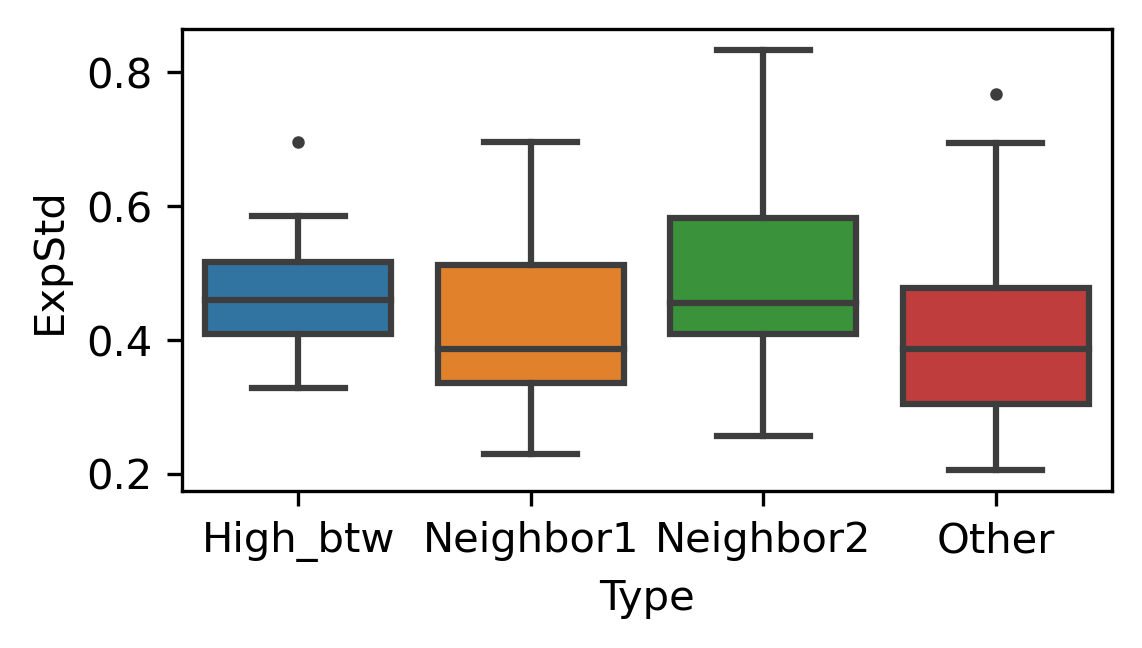

In [11]:
plt.figure(dpi=300, figsize=(4,2))
flierprops = dict(marker='o')
sns.boxplot(data=result, x='Type', y='ExpStd', fliersize=2, flierprops=flierprops)
plt.savefig('ExpStd.pdf', dpi='figure', bbox_inches='tight')

In [12]:
ttest_ind(result.loc[result['Type'] == "High_btw", "ExpMean"].values,
          result.loc[result['Type'] == "Neighbor1", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=1.423182047344679, pvalue=0.16815128346292801)

In [13]:
ttest_ind(result.loc[result['Type'] == "High_btw", "ExpMean"].values,
          result.loc[result['Type'] == "Neighbor2", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=2.36425830809877, pvalue=0.028489194397450592)

In [14]:
ttest_ind(result.loc[result['Type'] == "High_btw", "ExpMean"].values,
          result.loc[result['Type'] == "Other", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=4.610214293562743, pvalue=0.00036914259002369444)

In [15]:
ttest_ind(result.loc[result['Type'] == "Neighbor1", "ExpMean"].values,
          result.loc[result['Type'] == "Neighbor2", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=1.1246261672314362, pvalue=0.26783514747260884)

In [16]:
ttest_ind(result.loc[result['Type'] == "Neighbor1", "ExpMean"].values,
          result.loc[result['Type'] == "Other", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=4.140014764691888, pvalue=0.0002515225800364572)

In [17]:
ttest_ind(result.loc[result['Type'] == "Neighbor2", "ExpMean"].values,
          result.loc[result['Type'] == "Other", "ExpMean"].values, equal_var=False)

Ttest_indResult(statistic=3.2312023486265655, pvalue=0.0031120679336501646)